In [1]:
import argparse
import sys
import time
import os
import math

import numpy as np

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
from torchvision import models

import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from itertools import product
import copy


In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

In [4]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')


In [5]:
# file 이름 형태: id+object_label1,object_label2+style_label1,style_label2+material_label1,material_label2.jpg
def read_data_from_file(file_path):
  file_list = os.listdir(file_path)
  ids = []
  artwork_labels_list = [[] for _ in range(3)]

  for file_name in file_list:
    # .jpg 제거
    file_name = file_name[0: len(file_name) - 4]
    parsing_list = file_name.split('+')
    if (parsing_list[0] == ''):
        continue
    ids.append(parsing_list[0])
    del parsing_list[0]

    for i, label in enumerate(parsing_list):
        label = label.lower()
        label_list = label.split(', ')
        label_list = list(filter(None, label_list))
        artwork_labels_list[i].append(label_list)
        
  artworks = pd.DataFrame(
      {"ID": ids, "object_labels": artwork_labels_list[0], "style_labels": artwork_labels_list[1], "material_labels": artwork_labels_list[2], "File": file_list})
  artworks.dropna()
  
  return artworks


def filterLabelsByFrequency(artworks, frequency):
  for column in artworks.filter(regex='labels'):
    label_freq = artworks[column].apply(
      lambda s: [x for x in s]).explode().value_counts().sort_values(ascending=False)

    # Create a list of rare labels
    rare = list(label_freq[label_freq < frequency].index)

    artworks[column] = artworks[column].apply(
      lambda s: [x for x in s if x not in rare])
    artworks[column] = artworks[column].apply(
      lambda s: s if len(s) != 0 else np.nan)

  artworks.dropna(inplace=True)
  return artworks


         ID         object_labels            style_labels  material_labels  \
21    10042      [genre painting]           [pointillism]  [crayon, paper]   
24    10043      [genre painting]    [post-impressionism]  [crayon, paper]   
120   10246  [religious painting]     [early renaissance]  [stained glass]   
125   10247  [religious painting]     [early renaissance]  [stained glass]   
156    1030      [genre painting]  [northern renaissance]     [oil, panel]   
...     ...                   ...                     ...              ...   
9472   9980    [sketch and study]           [pointillism]      [oil, wood]   
9473   9982      [genre painting]           [pointillism]    [oil, canvas]   
9474   9983      [genre painting]           [pointillism]    [oil, canvas]   
9475   9985      [genre painting]           [pointillism]      [oil, wood]   
9476   9986           [landscape]           [pointillism]    [oil, canvas]   

                                                   File  
21   

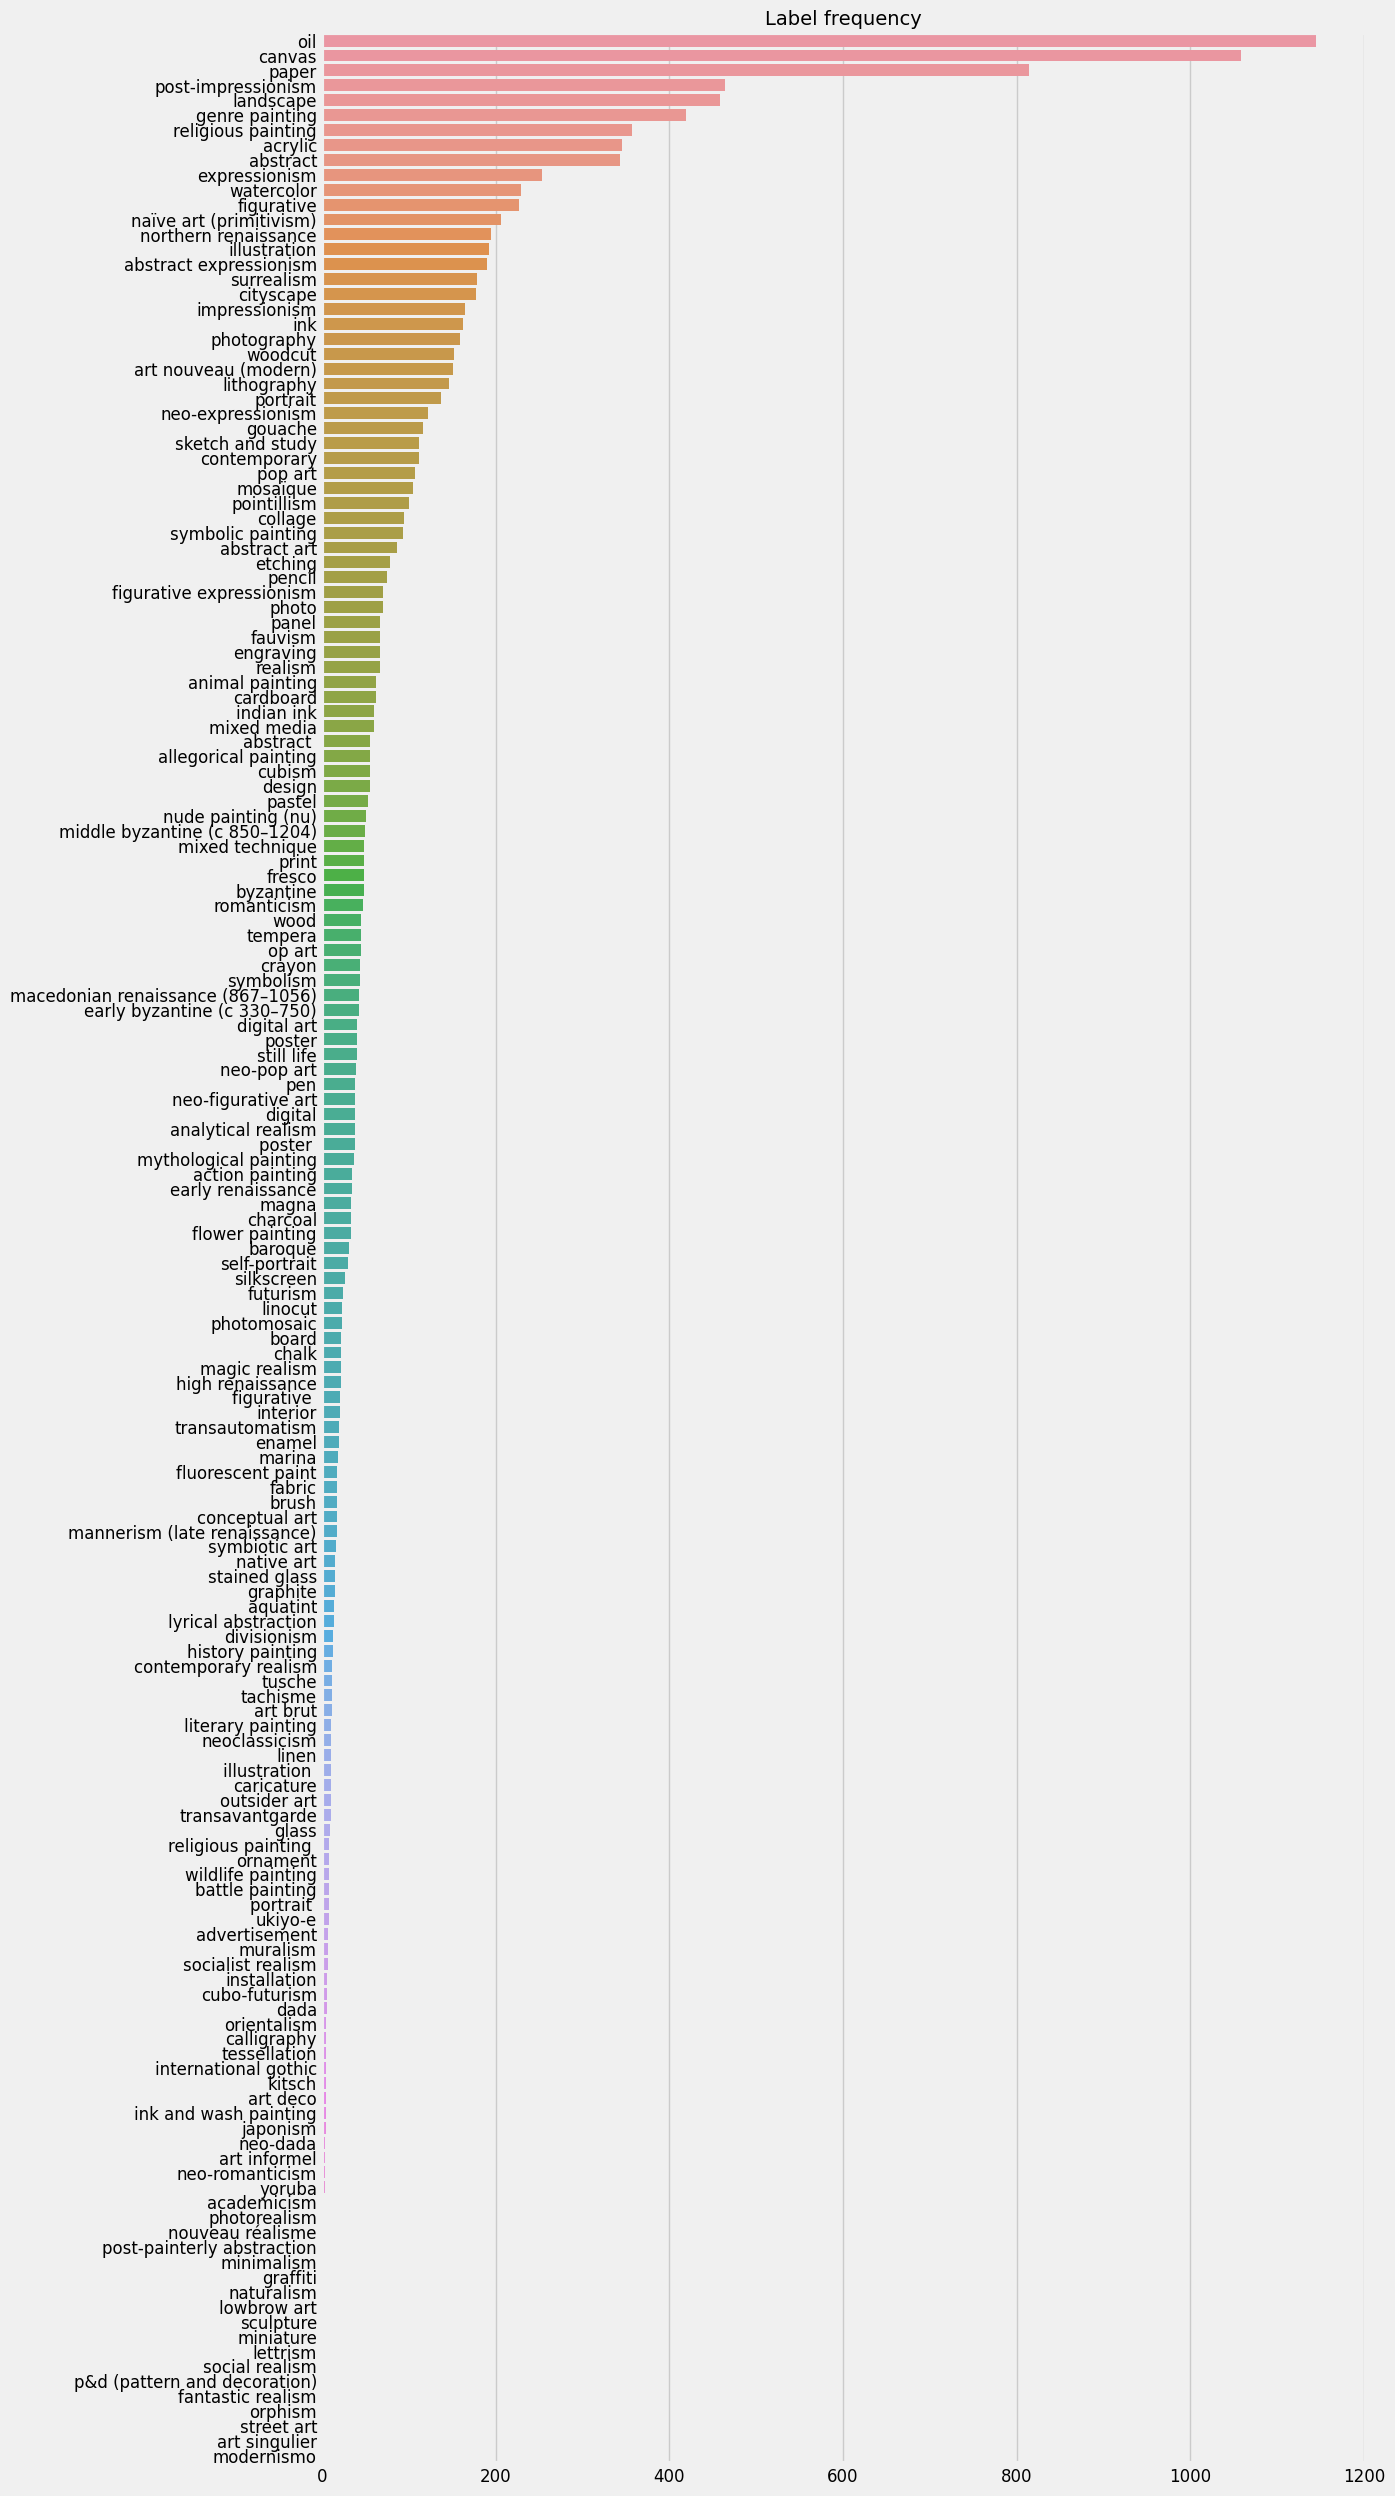

In [6]:
artworks = read_data_from_file('./database_test')
artworks = filterLabelsByFrequency(artworks, 10)
print(artworks)

object_label_freq = artworks['object_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()
style_label_freq = artworks['style_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()
material_label_freq = artworks['material_labels'].apply(
    lambda s: [x for x in s]).explode().value_counts()

label_freq = pd.concat([object_label_freq, style_label_freq,
                       material_label_freq]).sort_values(ascending=False)

style.use("fivethirtyeight")
plt.figure(figsize=(12, 30))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [7]:
def count_labels(label_list):
    total_labels = []
    for labels in label_list:
      labels = list(filter(None, labels))
      total_labels.extend(labels)

    return len(list(set(total_labels))), list(set(total_labels))


def get_index_of_np(numpy, val):
  index_np = np.where(numpy == val)[0]

  if index_np.size != 1:
    print('a', index_np[0], index_np.size, val)
    return None
  else:
    return index_np[0]
  
def get_adjacency_matrix(artwork_labels_list, total_labels, N_LABEL):
  adjacency_matrix = np.zeros((N_LABEL, N_LABEL))
  
  for artwork_labels in artwork_labels_list:
    label_combinations = list(product(artwork_labels, repeat=2))
    
    for label_combination in label_combinations:
      pivot_index = get_index_of_np(total_labels, label_combination[0])
      target_index = get_index_of_np(total_labels, label_combination[1])
      if (pivot_index is None) or (target_index is None):
        return None
      else:
        adjacency_matrix[pivot_index][target_index] += 1

  for row_index, row in enumerate(adjacency_matrix):
    basis = row[row_index]
    for col_index, val in enumerate(row):
      row[col_index] = val/basis
    
  return adjacency_matrix


def get_feature_matrix():
  return

def convert_to_graph(artworks):
  label_classes = ['object_labels', 'style_labels', 'material_labels']
  artwork_labels_list=[]
  labels_list_by_class = [set() for _ in range(3)]

  for index, label_class in enumerate(label_classes):
    labels_group = artworks[label_class]

    if index == 0:
      for labels in labels_group:
        artwork_labels_list.append(copy.deepcopy(labels))
        labels_list_by_class[index] = labels_list_by_class[index].union(set(copy.deepcopy(labels)))
    else:
      for i, labels in enumerate(labels_group):
        artwork_labels_list[i].extend(copy.deepcopy(labels))
        labels_list_by_class[index] = labels_list_by_class[index].union(
            set(copy.deepcopy(labels)))
  
  N_LABEL, total_labels = count_labels(artwork_labels_list)
  adjacency_matrix = get_adjacency_matrix(
      artwork_labels_list, np.array(total_labels), N_LABEL)
  
  class_one_hot_encoding_matrix = np.zeros((N_LABEL, 3))

  for i in range(N_LABEL):
    label = total_labels[i]
    for j in range(3):
      class_one_hot_encoding_matrix[i][j] = np.any(
          np.array(list(labels_list_by_class[j])) == label)
  
  embedding = nn.Embedding(N_LABEL, embedding_dim=5)
  input = torch.tensor(range(len(total_labels)))
  word_embedding_matrix = embedding(input).detach().cpu().numpy()
  
  feature_matrix = np.concatenate((class_one_hot_encoding_matrix, word_embedding_matrix), axis=1)
  
  return adjacency_matrix, feature_matrix, N_LABEL, total_labels


In [8]:
adjacency_matrix, feature_matrix, N_LABEL, total_labels = convert_to_graph(
    artworks)

In [9]:
artworks['labels'] = artworks['object_labels'] + artworks['style_labels'] + artworks['material_labels']

dataset_size = len(artworks)
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.2)
test_size = int(validation_size * 0.5)

X_train, X_val, y_train, y_val = train_test_split(
    artworks['File'], artworks['labels'], test_size=0.2, random_state=23)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, test_size=0.5, random_state=23)

X_train = [os.path.join('./database_test', str(f)) for f in X_train]
X_val = [os.path.join('./database_test', str(f)) for f in X_val]
X_test = [os.path.join('./database_test', str(f)) for f in X_test]

label_list = pd.DataFrame({'labels': [total_labels]})
mlb = MultiLabelBinarizer()
mlb.fit(label_list['labels'])

y_train = list(y_train)
y_val = list(y_val)
y_test = list(y_test)
y_train_bin = mlb.transform(y_train).astype(np.float64)
y_val_bin = mlb.transform(y_val).astype(np.float64)
y_test_bin = mlb.transform(y_test).astype(np.float64)

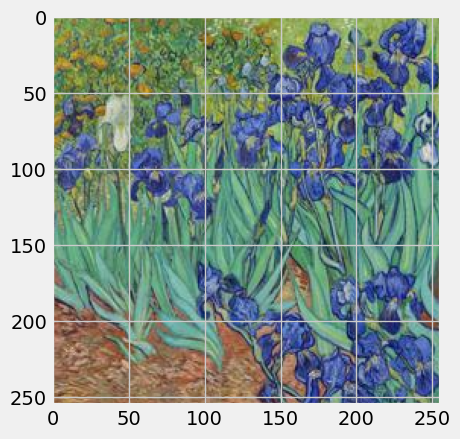

In [10]:
from PIL import Image
sample_image = Image.open(X_train[0])
plt.imshow(sample_image, cmap='gray')


In [11]:
class ArtworksDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        img = Image.open(self.X[index]).convert('RGB')
        label = torch.tensor(self.y[index], dtype=torch.float32)

        if self.transform:
            img = self.transform(img)

        return img, label


In [12]:
def get_dataloader(X, y, batch_size, mode='train'):
    if mode == 'train':
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
        ])

    dataset = ArtworksDataset(X, y, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size,
                            shuffle=True, generator=torch.Generator(device=device))
    total_batch = dataset.__len__() // batch_size
    return dataloader, total_batch


In [13]:
class GCNLayer(nn.Module):
  def __init__(self, in_dim, out_dim, n_label, act=None, bn=False):
    super(GCNLayer, self).__init__()

    self.use_bn = bn
    self.linear = nn.Linear(in_dim, out_dim)
    nn.init.xavier_uniform(self.linear.weight)
    self.bn = nn.BatchNorm1d(n_label)
    self.activation = act

  def forward(self, x, adj):
    out = self.linear(x)
    out = torch.matmul(adj, out)
    if self.use_bn:
      out = self.bn(out)
    if self.activation != None:
      out = self.activation(out)

    return out, adj

In [14]:
class GatedSkipConnection(nn.Module):
  def __init__(self, in_dim, out_dim):
    super(GatedSkipConnection, self).__init__()

    self.in_dim = in_dim
    self.out_dim = out_dim

    self.linear = nn.Linear(in_dim, out_dim, bias=False)
    self.linear_coef_in = nn.Linear(out_dim, out_dim)
    self.linear_coef_out = nn.Linear(out_dim, out_dim)
    self.sigmoid = nn.Sigmoid()

  def forward(self, in_x, out_x):
    if (self.in_dim != self.out_dim):
        in_x = self.linear(in_x)
    z = self.gate_coefficient(in_x, out_x)
    out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
    return out

  def gate_coefficient(self, in_x, out_x):
    x1 = self.linear_coef_in(in_x)
    x2 = self.linear_coef_out(out_x)
    return self.sigmoid(x1+x2)

In [15]:
class GCNBlock(nn.Module):
  def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, sc='gsc'):
    super(GCNBlock, self).__init__()

    self.layers = nn.ModuleList()
    for i in range(n_layer):
        self.layers.append(GCNLayer(in_dim if i == 0 else hidden_dim,
                                    out_dim if i == n_layer-1 else hidden_dim,
                                    n_atom,
                                    nn.ReLU() if i != n_layer-1 else None,
                                    bn))
    self.relu = nn.ReLU()
    if sc == 'gsc':
        self.sc = GatedSkipConnection(in_dim, out_dim)
    elif sc == 'no':
        self.sc = None
    else:
        assert False, "Wrong sc type."

  def forward(self, x, adj):
    residual = x
    for i, layer in enumerate(self.layers):
        out, adj = layer((x if i == 0 else out), adj)
    if self.sc != None:
        out = self.sc(residual, out)
    out = self.relu(out)
    return out, adj

In [16]:
class InceptionModule(nn.Module):
  def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, sc='gsc'):
    super(InceptionModule, self).__init__()
    self.GCNBlocks = nn.ModuleList()
    for i in range(n_layer):
      self.GCNBlocks.append(GCNBlock(i,
                                    in_dim,
                                    hidden_dim,
                                    out_dim))
  def forward(self, x, adj):
    outs = []
    for i, block in enumerate(self.GCNBlocks):
      outs.append(block(x, adj))

    feature_concatenate = torch.cat(outs, 2)
    return feature_concatenate, adj

In [17]:
class ReadOut(nn.Module):

    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim

        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out

In [18]:
class GCNNet(nn.Module):
  def __init__(self, args):
    super(GCNNet, self).__init__()


In [ ]:
# Define the model architecture
class Resnet50(nn.Module):
    def __init__(self, n_label):
        super(Resnet50, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(num_ftrs, n_label)
        )

    def forward(self, x):
        x = self.resnet(x)
        return x


In [ ]:
def multi_label_metrics(y_true, y_pred):
    """
    다중 레이블 분류 문제에서 Precision, recall, F1 score 계산 함수
    
    Args:
        y_true (torch.Tensor): 정답 레이블. shape: (batch_size, num_classes)
        y_pred (torch.Tensor): 모델 예측 레이블. shape: (batch_size, num_classes)
        
    Returns:
        precision (float): Precision 값
        recall (float): Recall 값
        f1_score (float): F1 Score 값
    """
    true_positives = torch.sum((y_true == 1) & (y_pred == 1), dim=0)
    false_positives = torch.sum((y_true == 0) & (y_pred == 1), dim=0)
    false_negatives = torch.sum((y_true == 1) & (y_pred == 0), dim=0)

    precision = torch.mean(
        true_positives / (true_positives + false_positives + 1e-8))
    recall = torch.mean(
        true_positives / (true_positives + false_negatives + 1e-8))
    f1_score = 2 * ((precision * recall) / (precision + recall + 1e-8))

    return precision.item(), recall.item(), f1_score.item()


In [19]:
def train(model, criterion, optimizer, batch_size, scheduler, num_epochs):
    train_loader, train_total_batch = get_dataloader(
        X_train, y_train_bin, batch_size, 'train')
    val_loader, val_total_batch = get_dataloader(
        X_val, y_val_bin, batch_size, 'val')
    
    train_acc_list = []
    train_loss_list = []
    val_loss_list = []
    val_acc_list = []
    best_val_loss = float('inf')
    patience = 0  # early stopping 관련 변수
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # 모델에 입력값 전달
            outputs = model(inputs)

            # 손실 계산
            loss = criterion(outputs, labels)

            # 기울기 초기화, 역전파, optimizer 업데이트
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 예측값 계산
            preds = torch.sigmoid(outputs) >= 0.5

            # labels를 binary list로 변환
            binary_labels = (labels.data > 0.5)
            
            # 정확도 계산, running_corrects의 범위는 0 ~ batch_size * N_LABEL
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds ==
                                          binary_labels)/ N_LABEL
            
        scheduler.step()

        # 에폭별 손실과 정확도
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_acc_list.append(epoch_acc)
        train_loss_list.append(epoch_loss)
        
        # validation set에서 모델 평가
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        for val_inputs, val_labels in val_loader:
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)

            # 모델에 입력값 전달
            val_outputs = model(val_inputs)

            # 손실 계산
            val_loss = criterion(val_outputs, val_labels)

            # 예측값 계산
            val_preds = torch.sigmoid(val_outputs) >= 0.5

            # labels를 binary list로 변환
            binary_val_labels = (val_labels.data > 0.5)

            # 정확도 계산
            val_running_loss += val_loss.item() * val_inputs.size(0)
            val_running_corrects += torch.sum(val_preds ==
                                              binary_val_labels)/N_LABEL

        # 에폭별 손실과 정확도
        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(val_loader.dataset)
        val_loss_list.append(val_epoch_loss)
        val_acc_list.append(val_epoch_acc)

        print('Epoch [{}/{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'
              .format(epoch+1, num_epochs, epoch_loss, epoch_acc, val_epoch_loss, val_epoch_acc))

        # early stopping 적용
        if val_epoch_loss < best_val_loss:
            if patience > 5:
                break
            best_val_loss = val_epoch_loss
            patience += 1
    return model, train_loss_list, train_acc_list

C:\Users\이성준\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\이성준\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], train_loss: 0.1003, train_acc: 0.9700, val_loss: 0.0804, val_acc: 0.9766
Epoch [2/10], train_loss: 0.0773, train_acc: 0.9772, val_loss: 0.0739, val_acc: 0.9781
Epoch [3/10], train_loss: 0.0735, train_acc: 0.9778, val_loss: 0.0712, val_acc: 0.9783
Epoch [4/10], train_loss: 0.0693, train_acc: 0.9788, val_loss: 0.0717, val_acc: 0.9780
Epoch [5/10], train_loss: 0.0669, train_acc: 0.9793, val_loss: 0.0703, val_acc: 0.9781
Epoch [6/10], train_loss: 0.0643, train_acc: 0.9798, val_loss: 0.0684, val_acc: 0.9783
Epoch [7/10], train_loss: 0.0608, train_acc: 0.9808, val_loss: 0.0646, val_acc: 0.9802
Epoch [8/10], train_loss: 0.0547, train_acc: 0.9823, val_loss: 0.0568, val_acc: 0.9822


In [ ]:
# Define the model, optimizer and loss function
model_resnet = Resnet50(N_LABEL).to(device)
optimizer_ft = optim.Adam(model_resnet.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(
    optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.MultiLabelSoftMarginLoss()

# Train the model
model_resnet, train_loss, train_acc = train(
    model_resnet, criterion, optimizer_ft, 32, exp_lr_scheduler, 10)
